### Replicamos los recursos locales en el entorno virtual

### Descargamos los datos de la competencia al entorno de trabajo

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.07GB/s]


### Descomprimimos el archivo

In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


## Importe de librerías necesarias

Instalamos la librería Unidecode con el objetivo de manejar las cadenas de texto específicamente de la columna "ESTU_PRGM_ACADEMICO". Esto dado que debemos convertirla a minúsculas, eliminar tíldes y procesarlas todas de la manera más uniforme posible.

In [ ]:
!pip install unidecode

Usamos las librerías


*   **Unidecode**: Para manejar los datos de la columna de programa académico con la intención de estandarizar la escritura de las mismas.
*   **Pandas**: Para manejar los datos en un objeto Dataframe y poderlos manipular de manera sencilla
*   **numpy**: Para manejar los datos numéricos, ordenar y estandarizar vectores y columnas del dataframe
*   **OneHotEncoder y OrdinalEncoder de Scikitlearn**: Para procesar algunas columnas categóricas aplicándoles OneHot y otras de manera ordinal.
*   **Seaborn**: Para el uso de gráficas de matrices de correlación entre variables con el objetivo de eliminar las variables redundantes.


In [ ]:
import unidecode as ud
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

### Cargamos el csv como un dataframe de Pandas
Se guarda en la variable train para usarlo durante todo el preprocesado

In [ ]:
train = pd.read_csv("train.csv")
print ("shape of loaded dataframe", train.shape)

shape of loaded dataframe (692500, 21)


Observamos qué columnas tiene el dataframe de Pandas al momento de cargarlo.

In [ ]:
train.columns

Index(['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD',
       'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR',
       'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL',
       'coef_1', 'coef_2', 'coef_3', 'coef_4'],
      dtype='object')

Observamos las primeras 5 filas del dataframe

In [ ]:
train.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


## One_hot encoding para la columna 'ESTU_PRGM_ACADEMICO'


#### Estrategia de preprocesado de 'ESTU_PRGM_ACADEMICO'

*   Observamos cuantas carreras únicas hay y cuales de estas son.
*   Las pasamos todas a minúsculas para que se agrupen algunas que eran las mismas pero escritas con diferentes combinaciones de mayúsculas y minúsculas.
*   Dejamos en un array de numpy solo las carreras que tengan más de 6000 apariciones en el Dataframe original. Con el objetivo de agrupar al rededor de 20 carreras diferentes.
*   A las demás carreras las agrupamos en un grupo 'otros' con el objetivo de reducir el ruido en los datos y la posible variabilidad que puedan presentar.
*   Aplicar OneHotEncoding a los nuevos datos en la columna.

In [ ]:
carreras_unicas = train['ESTU_PRGM_ACADEMICO'].unique()
len(carreras_unicas)

948

In [ ]:
train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(lambda x: ud.unidecode(x.lower()))

In [ ]:
carreras_unicas = train['ESTU_PRGM_ACADEMICO'].unique()
len(carreras_unicas)

786

In [ ]:
train.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,enfermeria,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,derecho,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,mercadeo y publicidad,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,administracion de empresas,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,psicologia,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [ ]:
counts = train['ESTU_PRGM_ACADEMICO'].value_counts().to_frame()
prgm_acads = (counts.loc[counts['count'] > 6000]).index
prgm_acads


Index(['administracion de empresas', 'derecho', 'contaduria publica',
       'psicologia', 'ingenieria industrial', 'ingenieria civil', 'medicina',
       'ingenieria de sistemas', 'licenciatura en pedagogia infantil',
       'ingenieria ambiental', 'trabajo social', 'enfermeria', 'arquitectura',
       'administracion en salud ocupacional', 'negocios internacionales',
       'economia', 'ingenieria mecanica', 'ingenieria electronica',
       'comunicacion social', 'administracion financiera'],
      dtype='object', name='ESTU_PRGM_ACADEMICO')

In [ ]:
len(prgm_acads)

20

In [ ]:
array = [element for element in train['ESTU_PRGM_ACADEMICO'] if element not in prgm_acads ]
array

condition = train['ESTU_PRGM_ACADEMICO'].isin(array)
train.loc[condition, 'ESTU_PRGM_ACADEMICO'] = "otros"
train.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,enfermeria,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,derecho,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,otros,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,administracion de empresas,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,psicologia,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


Los programas académicos quedan entonces de la siguiente manera después del procesado de preparación para aplicarles el OneHot Encoding.

In [ ]:
train['ESTU_PRGM_ACADEMICO'].value_counts()

,count
ESTU_PRGM_ACADEMICO,
otros,251299
administracion de empresas,76679
derecho,53244
contaduria publica,51846
psicologia,49309
ingenieria industrial,34794
ingenieria civil,20943
medicina,18099
ingenieria de sistemas,18028


POr último, codificamos con OneHot la columna 'ESTU_PROGRAMA_ACADEMICO'

In [ ]:
encode = OneHotEncoder()

codificadorPrg = encode.fit_transform(train[['ESTU_PRGM_ACADEMICO']])

arreglo = pd.DataFrame(codificadorPrg.toarray(), columns = encode.categories_)
print(arreglo)
train.drop('ESTU_PRGM_ACADEMICO', axis = 1)

train = pd.concat([train, arreglo], axis = 'columns')
train['ESTU_PRGM_ACADEMICO']

       administracion de empresas administracion en salud ocupacional  \
0                             0.0                                 0.0   
1                             0.0                                 0.0   
2                             0.0                                 0.0   
3                             1.0                                 0.0   
4                             0.0                                 0.0   
...                           ...                                 ...   
692495                        0.0                                 0.0   
692496                        0.0                                 0.0   
692497                        0.0                                 1.0   
692498                        0.0                                 0.0   
692499                        0.0                                 0.0   

       administracion financiera arquitectura comunicacion social  \
0                            0.0          0.0         

,ESTU_PRGM_ACADEMICO
0,enfermeria
1,derecho
2,otros
3,administracion de empresas
4,psicologia
...,...
692495,otros
692496,psicologia
692497,administracion en salud ocupacional
692498,psicologia


Borramos la columna 'ESTU_PRGM_ACADEMICO' ya que no sirve para nada ahora que aplicamos el OneHot encoding a la misma.

In [ ]:
train = train.drop('ESTU_PRGM_ACADEMICO', axis = 1)

#### Dataset con preprocesado de la columna 'ESTU_PRGM_ACADEMICO'

In [ ]:
train.head()

,ID,PERIODO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,...,"(ingenieria de sistemas,)","(ingenieria electronica,)","(ingenieria industrial,)","(ingenieria mecanica,)","(licenciatura en pedagogia infantil,)","(medicina,)","(negocios internacionales,)","(otros,)","(psicologia,)","(trabajo social,)"
0,904256,20212,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,645256,20212,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,308367,20203,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,470353,20195,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,989032,20212,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Categorización ordinal de las columnas categóricas ordinales

In [ ]:
train.columns

Index([                                    'ID',
                                      'PERIODO',
                       'ESTU_PRGM_DEPARTAMENTO',
               'ESTU_VALORMATRICULAUNIVERSIDAD',
                      'ESTU_HORASSEMANATRABAJA',
                         'FAMI_ESTRATOVIVIENDA',
                           'FAMI_TIENEINTERNET',
                          'FAMI_EDUCACIONPADRE',
                           'FAMI_TIENELAVADORA',
                          'FAMI_TIENEAUTOMOVIL',
                        'ESTU_PRIVADO_LIBERTAD',
                     'ESTU_PAGOMATRICULAPROPIO',
                         'FAMI_TIENECOMPUTADOR',
                         'FAMI_TIENEINTERNET.1',
                          'FAMI_EDUCACIONMADRE',
                           'RENDIMIENTO_GLOBAL',
                                       'coef_1',
                                       'coef_2',
                                       'coef_3',
                                       'coef_4',
                ('ad

## Quitarle los valores nulos a todas las columnas categóricas ordinales


### Conteo de valores nulos

In [ ]:
train['FAMI_EDUCACIONMADRE'].value_counts()

,count
FAMI_EDUCACIONMADRE,
Secundaria (Bachillerato) completa,141744
Primaria incompleta,99420
Técnica o tecnológica completa,89542
Educación profesional completa,85326
Secundaria (Bachillerato) incompleta,81012
Primaria completa,56125
Postgrado,46246
Técnica o tecnológica incompleta,27533
Educación profesional incompleta,22470


In [ ]:
print(f"Cantidad nulos valor matrícula = {train['ESTU_VALORMATRICULAUNIVERSIDAD'].isna().sum()}")
print(f"Cantidad nulos horas semanales trabaja = {train['ESTU_HORASSEMANATRABAJA'].isna().sum()}")
print(f"Cantidad nulos estrato vivienda = {train['FAMI_ESTRATOVIVIENDA'].isna().sum()}")
print(f"Cantidad nulos educación padre = {train['FAMI_EDUCACIONPADRE'].isna().sum()}")
print(f"Cantidad nulos educación madre = {train['FAMI_EDUCACIONMADRE'].isna().sum()}")
print(f"Cantidad nulos rendimiento global = {train['RENDIMIENTO_GLOBAL'].isna().sum()}")

Cantidad nulos valor matrícula = 6287
Cantidad nulos horas semanales trabaja = 30857
Cantidad nulos estrato vivienda = 32137
Cantidad nulos educación padre = 23178
Cantidad nulos educación madre = 23664
Cantidad nulos rendimiento global = 0


### Cambio de valores nulos por 'no info'

In [ ]:
train['ESTU_VALORMATRICULAUNIVERSIDAD'] = train['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna("no info")
train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].fillna("no info")
train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].fillna("no info")
train['FAMI_EDUCACIONPADRE'] = train['FAMI_EDUCACIONPADRE'].fillna("no info")
train['FAMI_EDUCACIONMADRE'] = train['FAMI_EDUCACIONMADRE'].fillna("no info")
train['RENDIMIENTO_GLOBAL'] = train['RENDIMIENTO_GLOBAL'].fillna("no info")

## Codificación de valores categóricos ordinales.

Agrupamos todas las categorías de las variables categóricas ordinales en un arreglo con el objetivo de aplicar la codificación con el OrdinalEncoder.

In [ ]:
categories = [
    ['no info', 'No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón',
     'Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones',
     'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones',
     'Más de 7 millones'],  # ESTU_VALORMATRICULAUNIVERSIDAD
    ['no info', '0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas'],  # ESTU_HORASSEMANATRABAJA
    ['no info', 'Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6'],  # FAMI_ESTRATOVIVIENDA
    ['no info', 'Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa',
     'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa', 'Técnica o tecnológica incompleta',
     'Técnica o tecnológica completa', 'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'],  # FAMI_EDUCACIONPADRE
    ['no info', 'Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa',
     'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa', 'Técnica o tecnológica incompleta',
     'Técnica o tecnológica completa', 'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'],  # FAMI_EDUCACIONMADRE
    ['no info', 'bajo', 'medio-bajo', 'medio-alto', 'alto']  # RENDIMIENTO_GLOBAL
]



In [ ]:
codificador = OrdinalEncoder(categories=categories)
train[['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE',
       'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL']] = codificador.fit_transform(
    train[['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
           'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL']]
       )

Así queda entonces el Dataset con la codificación de las columnas ordinales.

In [ ]:
train.head()

,ID,PERIODO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,...,"(ingenieria de sistemas,)","(ingenieria electronica,)","(ingenieria industrial,)","(ingenieria mecanica,)","(licenciatura en pedagogia infantil,)","(medicina,)","(negocios internacionales,)","(otros,)","(psicologia,)","(trabajo social,)"
0,904256,20212,BOGOTÁ,7.0,2.0,4.0,Si,8.0,Si,Si,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,645256,20212,ATLANTICO,5.0,1.0,4.0,No,9.0,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,308367,20203,BOGOTÁ,5.0,5.0,4.0,Si,7.0,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,470353,20195,SANTANDER,6.0,1.0,5.0,Si,2.0,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,989032,20212,ANTIOQUIA,5.0,4.0,4.0,Si,5.0,Si,Si,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train['ESTU_PAGOMATRICULAPROPIO'] = train['ESTU_PAGOMATRICULAPROPIO'].fillna('no info')
train['ESTU_PAGOMATRICULAPROPIO'].value_counts()

,count
ESTU_PAGOMATRICULAPROPIO,
No,382201
Si,303801
no info,6498


In [ ]:
train = train[train['ESTU_PAGOMATRICULAPROPIO'] != 'no info']

In [ ]:
train['ESTU_PAGOMATRICULAPROPIO'].value_counts()

,count
ESTU_PAGOMATRICULAPROPIO,
No,382201
Si,303801


In [ ]:
print(f"Cantidad nulos tiene internet = {train['ESTU_PAGOMATRICULAPROPIO'].isna().sum()}")
train['FAMI_TIENEINTERNET'].value_counts()

Cantidad nulos tiene internet = 0


,count
FAMI_TIENEINTERNET,
Si,588047
No,73033


## Conversión One-Hot de las columnas FAMI_TIENEINTERNET y ESTU_PAGOMATRICULAPROPIO

In [ ]:
one_hot_encoded = pd.get_dummies(train['ESTU_PAGOMATRICULAPROPIO'], prefix = 'ESTU_PAGOMATRICULAPROPIO')
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoded

,ESTU_PAGOMATRICULAPROPIO_No,ESTU_PAGOMATRICULAPROPIO_Si
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
692495,0,1
692496,1,0
692497,0,1
692498,0,1


In [ ]:
train = pd.concat([train, one_hot_encoded], axis = 1)
train = train.drop('ESTU_PAGOMATRICULAPROPIO', axis = 1)

In [ ]:
train['ESTU_PAGOMATRICULAPROPIO_No'].head()

,ESTU_PAGOMATRICULAPROPIO_No
0,1
1,1
2,1
3,1
4,1


In [ ]:
print(train.columns)

Index([                                    'ID',
                                      'PERIODO',
                       'ESTU_PRGM_DEPARTAMENTO',
               'ESTU_VALORMATRICULAUNIVERSIDAD',
                      'ESTU_HORASSEMANATRABAJA',
                         'FAMI_ESTRATOVIVIENDA',
                           'FAMI_TIENEINTERNET',
                          'FAMI_EDUCACIONPADRE',
                           'FAMI_TIENELAVADORA',
                          'FAMI_TIENEAUTOMOVIL',
                        'ESTU_PRIVADO_LIBERTAD',
                         'FAMI_TIENECOMPUTADOR',
                         'FAMI_TIENEINTERNET.1',
                          'FAMI_EDUCACIONMADRE',
                           'RENDIMIENTO_GLOBAL',
                                       'coef_1',
                                       'coef_2',
                                       'coef_3',
                                       'coef_4',
                ('administracion de empresas',),
       ('administrac

In [ ]:
one_hot_encoded = pd.get_dummies(train['FAMI_TIENEINTERNET'], prefix = 'FAMI_TIENEINTERNET')
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoded

,FAMI_TIENEINTERNET_No,FAMI_TIENEINTERNET_Si
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
692495,0,1
692496,0,1
692497,0,1
692498,1,0


In [ ]:
train = pd.concat([train, one_hot_encoded], axis = 1)
train = train.drop('FAMI_TIENEINTERNET', axis = 1)

In [ ]:
train['FAMI_TIENEINTERNET_Si'].head()

,FAMI_TIENEINTERNET_Si
0,1
1,0
2,1
3,1
4,1


### Procesamiento de la columna Departamento

Separamos los departamentos con más y menos incidencia de la pobreza monetaria según los datos DANE. Esto porque consideramos que es un factor importante a la hora de la calidad educativa en todas las regiones de Colombia.

In [ ]:
richest_deps = ['BOGOTÁ', 'RISARALDA', 'SANTANDER', 'ANTIOQUIA', 'CALDAS', 'CUNDINAMARCA', 'META', 'VALLE', 'QUINDIO', 'ATLANTICO', 'BOYACA']

In [ ]:
train['ESTU_PRGM_DEPARTAMENTO'] = train['ESTU_PRGM_DEPARTAMENTO'].apply(lambda x: 1 if x in richest_deps else 0)

In [ ]:
train['ESTU_PRGM_DEPARTAMENTO'].values

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
train.columns

Index([                                    'ID',
                                      'PERIODO',
                       'ESTU_PRGM_DEPARTAMENTO',
               'ESTU_VALORMATRICULAUNIVERSIDAD',
                      'ESTU_HORASSEMANATRABAJA',
                         'FAMI_ESTRATOVIVIENDA',
                          'FAMI_EDUCACIONPADRE',
                           'FAMI_TIENELAVADORA',
                          'FAMI_TIENEAUTOMOVIL',
                        'ESTU_PRIVADO_LIBERTAD',
                         'FAMI_TIENECOMPUTADOR',
                         'FAMI_TIENEINTERNET.1',
                          'FAMI_EDUCACIONMADRE',
                           'RENDIMIENTO_GLOBAL',
                                       'coef_1',
                                       'coef_2',
                                       'coef_3',
                                       'coef_4',
                ('administracion de empresas',),
       ('administracion en salud ocupacional',),
                 ('a

### Eliminamos la columna periodo y ID ya que se considera, no tiene efecto sobre el rendimiento

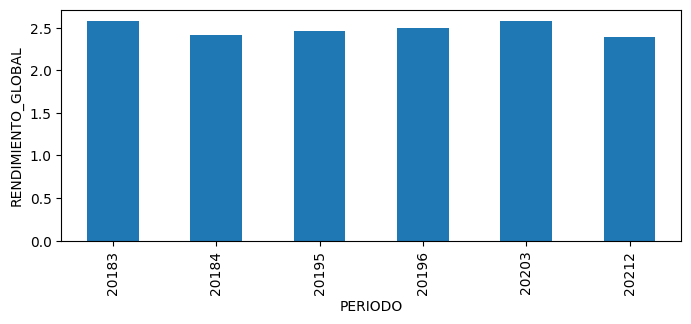

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,3))
train.groupby('PERIODO')['RENDIMIENTO_GLOBAL'].mean().plot(kind='bar', ax=ax)
ax.set_xlabel('PERIODO')
ax.set_ylabel('RENDIMIENTO_GLOBAL')
plt.show()

In [ ]:
train = train.drop('PERIODO', axis = 1)
train = train.drop('ID', axis = 1)

In [ ]:
train.head()

,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,...,"(licenciatura en pedagogia infantil,)","(medicina,)","(negocios internacionales,)","(otros,)","(psicologia,)","(trabajo social,)",ESTU_PAGOMATRICULAPROPIO_No,ESTU_PAGOMATRICULAPROPIO_Si,FAMI_TIENEINTERNET_No,FAMI_TIENEINTERNET_Si
0,1,7.0,2.0,4.0,8.0,Si,Si,N,Si,Si,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1,1,5.0,1.0,4.0,9.0,Si,No,N,Si,No,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
2,1,5.0,5.0,4.0,7.0,Si,No,N,No,Si,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1
3,1,6.0,1.0,5.0,2.0,Si,No,N,Si,Si,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
4,1,5.0,4.0,4.0,5.0,Si,Si,N,Si,Si,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,1


In [ ]:
np.unique(train['ESTU_HORASSEMANATRABAJA'].values)

array([0., 1., 2., 3., 4., 5.])

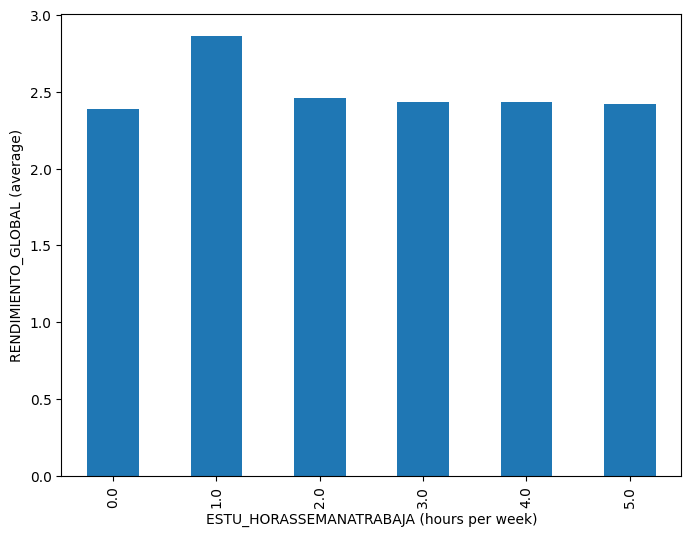

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
train.groupby('ESTU_HORASSEMANATRABAJA')['RENDIMIENTO_GLOBAL'].mean().plot(kind='bar', ax=ax)
ax.set_xlabel('ESTU_HORASSEMANATRABAJA (hours per week)')
ax.set_ylabel('RENDIMIENTO_GLOBAL (average)')
plt.show()

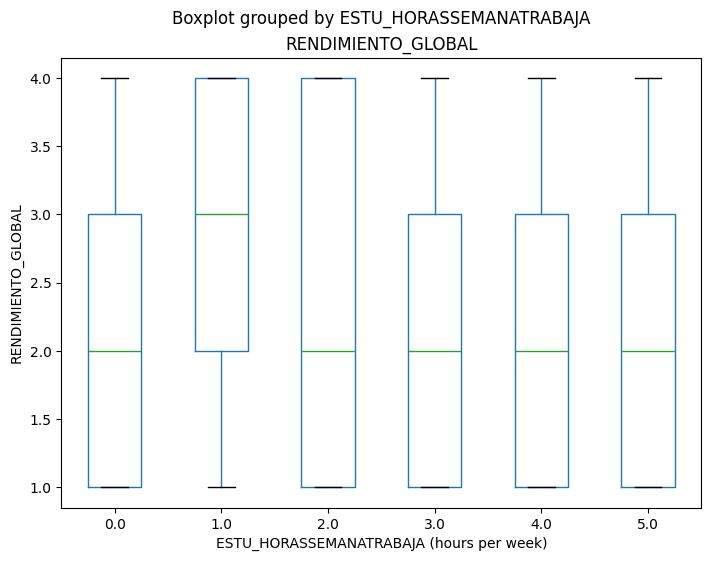

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
train.boxplot(column='RENDIMIENTO_GLOBAL', by='ESTU_HORASSEMANATRABAJA', ax=ax)
ax.set_xlabel('ESTU_HORASSEMANATRABAJA (hours per week)')
ax.set_ylabel('RENDIMIENTO_GLOBAL')
plt.grid(False)
plt.show()

In [ ]:
print(train['ESTU_HORASSEMANATRABAJA'].dtype)

float64


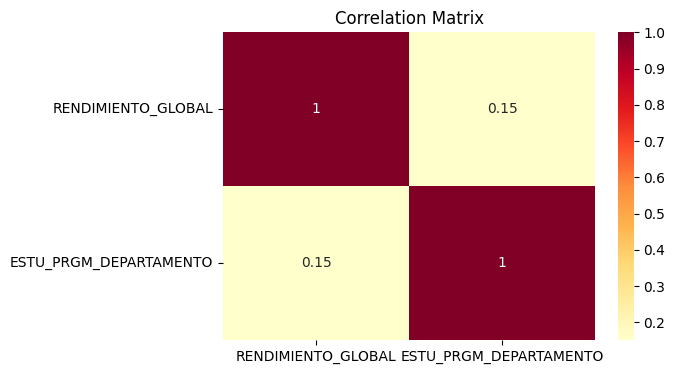

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'ESTU_PRGM_DEPARTAMENTO']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].astype(int)

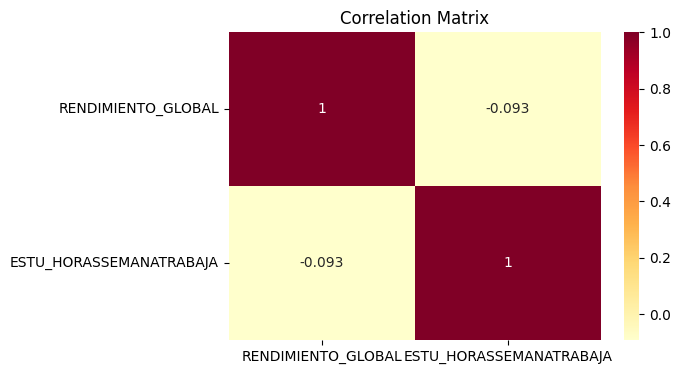

In [ ]:
import seaborn as sns

corr_matrix = train[['RENDIMIENTO_GLOBAL', 'ESTU_HORASSEMANATRABAJA']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

Como la variable ESTU_HORASSEMANATRABAJA no tiene prácticamente correlación con el rendimiento global, entonces la eliminamos para quitar ruido del dataset

In [ ]:
train = train.drop('ESTU_HORASSEMANATRABAJA', axis = 1)

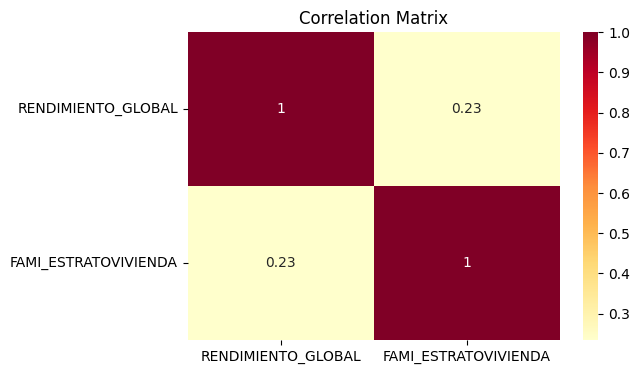

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'FAMI_ESTRATOVIVIENDA']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

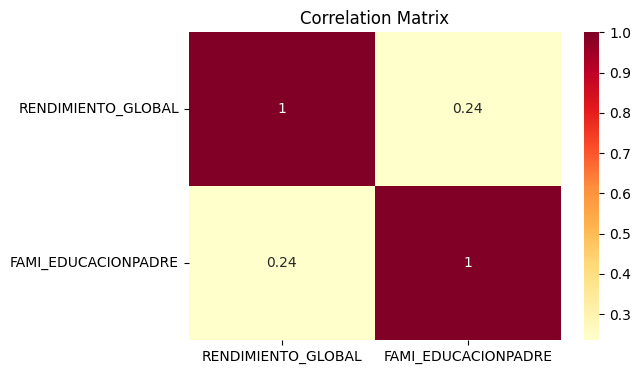

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'FAMI_EDUCACIONPADRE']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

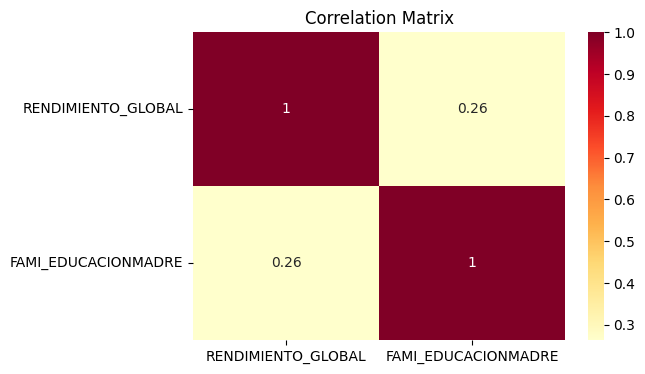

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'FAMI_EDUCACIONMADRE']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

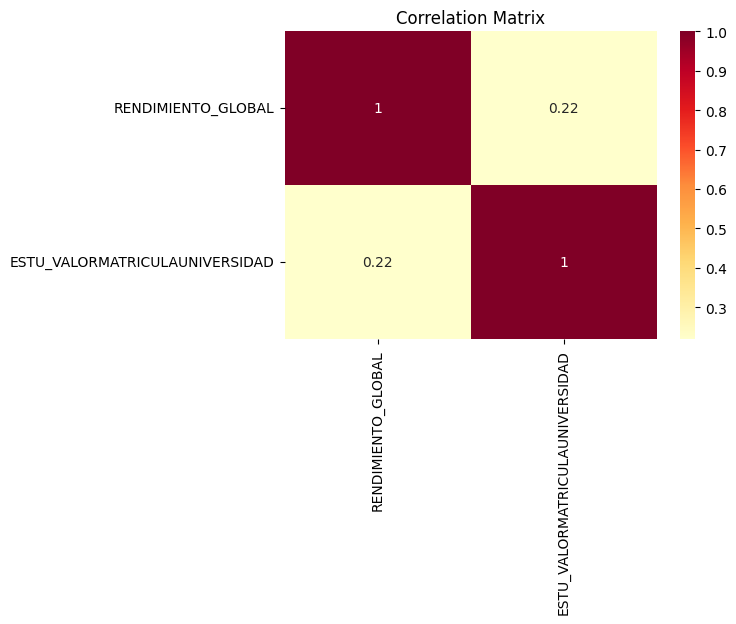

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'ESTU_VALORMATRICULAUNIVERSIDAD']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

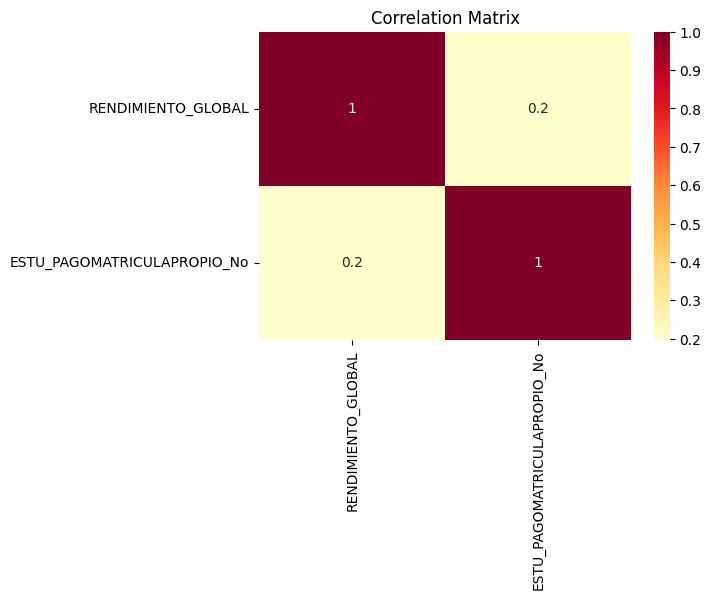

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'ESTU_PAGOMATRICULAPROPIO_No']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

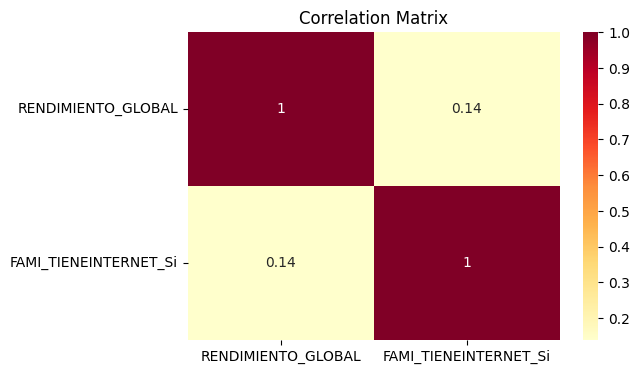

In [ ]:
corr_matrix = train[['RENDIMIENTO_GLOBAL', 'FAMI_TIENEINTERNET_Si']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
train.columns

Index([                'ESTU_PRGM_DEPARTAMENTO',
               'ESTU_VALORMATRICULAUNIVERSIDAD',
                         'FAMI_ESTRATOVIVIENDA',
                          'FAMI_EDUCACIONPADRE',
                           'FAMI_TIENELAVADORA',
                          'FAMI_TIENEAUTOMOVIL',
                        'ESTU_PRIVADO_LIBERTAD',
                         'FAMI_TIENECOMPUTADOR',
                         'FAMI_TIENEINTERNET.1',
                          'FAMI_EDUCACIONMADRE',
                           'RENDIMIENTO_GLOBAL',
                                       'coef_1',
                                       'coef_2',
                                       'coef_3',
                                       'coef_4',
                ('administracion de empresas',),
       ('administracion en salud ocupacional',),
                 ('administracion financiera',),
                              ('arquitectura',),
                       ('comunicacion social',),
                    

In [ ]:
train.to_csv('train3.csv', index = False)

In [ ]:
!head train3.csv

ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4,"('administracion de empresas',)","('administracion en salud ocupacional',)","('administracion financiera',)","('arquitectura',)","('comunicacion social',)","('contaduria publica',)","('derecho',)","('economia',)","('enfermeria',)","('ingenieria ambiental',)","('ingenieria civil',)","('ingenieria de sistemas',)","('ingenieria electronica',)","('ingenieria industrial',)","('ingenieria mecanica',)","('licenciatura en pedagogia infantil',)","('medicina',)","('negocios internacionales',)","('otros',)","('psicologia',)","('trabajo social',)",ESTU_PAGOMATRICULAPROPIO_No,ESTU_PAGOMATRICULAPROPIO_Si,FAMI_TIENEINTERNET_No,FAMI_TIENEINTERNET_Si
1,7.0,4.0,8.0,Si,Si,N,Si,Si,12.0,3.0,0.322,0.208,0.31,0.267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,